<a href="https://www.kaggle.com/ardalandaneshvar/breast-cancer-classification-softvote?scriptVersionId=83723592" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Breast Cancer Softvote Classification (Ensemble Model)

###  What is our goal?
Our goal is to make a classifier which can classify new instances as "Malignant" or "Benign" without overfitting on the training set. 
<br>We will achieve this by using cross validation and making an ensemble model.
<br>The ensemble model is based on three different classifiers which are separately good enough.

In [1]:
#Importing all packages used in this notebook.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/breast-cancer-wisconsin-data/data.csv


First of all we need to load the data as a pandas dataframe.

In [2]:
dataset = pd.read_csv("../input/breast-cancer-wisconsin-data/data.csv")

After importing the dataset we need to get an insight about the dataset.(Basic information)
<br>In order to do this we return the column names.

In [3]:
dataset.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

As someone who has no domain expertise,Its better to do some EDA...
<br>Before getting into detail it is better to take a simple look at the dataset, therefore we return 7 random samples from the dataset.(7 is my lucky number)

In [4]:
dataset.sample(7)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
238,883270,B,14.22,27.85,92.55,623.9,0.08223,0.10390,0.11030,0.044080,...,40.54,102.50,764.0,0.1081,0.24260,0.306400,0.082190,0.1890,0.07796,NaN
418,906024,B,12.70,12.17,80.88,495.0,0.08785,0.05794,0.02360,0.024020,...,16.92,88.12,566.9,0.1314,0.16070,0.093850,0.082240,0.2775,0.09464,NaN
254,886226,M,19.45,19.33,126.50,1169.0,0.10350,0.11880,0.13790,0.085910,...,24.57,163.10,1972.0,0.1497,0.31610,0.431700,0.199900,0.3379,0.08950,NaN
122,865423,M,24.25,20.20,166.20,1761.0,0.14470,0.28670,0.42680,0.201200,...,23.99,180.90,2073.0,0.1696,0.42440,0.580300,0.224800,0.3222,0.08009,NaN
285,8912521,B,12.58,18.40,79.83,489.0,0.08393,0.04216,0.00186,0.002924,...,23.08,85.56,564.1,0.1038,0.06624,0.005579,0.008772,0.2505,0.06431,NaN
182,873701,M,15.70,20.31,101.20,766.6,0.09597,0.08799,0.06593,0.051890,...,32.82,129.30,1269.0,0.1414,0.35470,0.290200,0.154100,0.3437,0.08631,NaN
562,925622,M,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.094290,...,42.79,128.70,915.0,0.1417,0.79170,1.170000,0.235600,0.4089,0.14090,NaN


Features have very different scales so that needs to be taken care of.
<br>And most importantly there's an unnamed feature called "Unnamed:32" which all random sample values are "NaN" for some reason.

How many of the instances are Malignant and how many are Benign?
<br>Knowing this is important, if one of the groups has more instances we can't split the training and test set randomly.(We need to perform stratifies sampling)

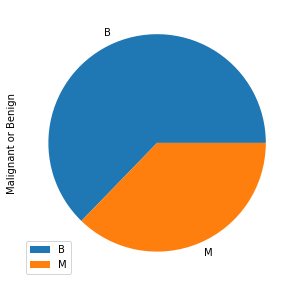

In [5]:
num_M_B = pd.Series(dataset.diagnosis.value_counts(),name="Malignant or Benign")
num_M_B = pd.DataFrame(num_M_B)
plot = num_M_B.plot.pie(y="Malignant or Benign", figsize=(5, 5))

Based on the pie chart instances with "Benign" label are more than the ones with "Malignant" label.
<br> So we need to perform stratified sampling.

Now we took a quick look at the dataset and need to gather more info in detail.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Surprisingly all values inside "Unnamed:32" are null values!So, we drop it all together.
<br>All features data types is float so we only need to scale the data.(Soon)
<br>We don't care about the "id" column since it is not a time series question.
<br>And at last we need to convert our labes into zeros and ones.(Since it's binary classification)

In [7]:
dataset.drop(["id","Unnamed: 32"],axis=1,inplace=True)
label_encoder = LabelEncoder()
dataset["diagnosis_encoded"] = label_encoder.fit_transform(dataset["diagnosis"]) 
dataset.drop(["diagnosis"],axis=1,inplace=True)
dataset.sample(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_encoded
371,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,0.05544,...,15.73,104.5,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766,0
94,15.06,19.83,100.30,705.6,0.10390,0.15530,0.17000,0.08815,0.1855,0.06284,...,24.23,123.5,1025.0,0.1551,0.4203,0.52030,0.21150,0.2834,0.08234,1
552,12.77,29.43,81.35,507.9,0.08276,0.04234,0.01997,0.01499,0.1539,0.05637,...,36.00,88.1,594.7,0.1234,0.1064,0.08653,0.06498,0.2407,0.06484,0


That looks better!

Lets look at the correlation between features.
<br>Since scaling features has no impact on correlations between them its a good idea to see what we are dealing with.

In [8]:
corr_matrix = dataset.corr()
corr_matrix["diagnosis_encoded"].sort_values(ascending=False)

diagnosis_encoded          1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

Wow!
<br>Most of the features have an impact on diagnosis.
<br>In this case its better not to drop any feature,instead its better to use some dimensionality reduction algorithm or let the model use feature importance. 
<br>Since the dataset is not very large we wont use dimensionality reduction and let the model handle the features.

In [9]:
dataset.shape

(569, 31)

Now we have 31 features and 569 instances.
<br>We also need to scale our data.(Scaling the dataset is essential since different features have different scales in this dataset.)
<br>After scaling our dataset its time to split our dataeset.(Stratified Sampling)

In [10]:
y = dataset["diagnosis_encoded"]
X = dataset.loc[:, dataset.columns != "diagnosis_encoded"]
X = StandardScaler().fit_transform(X)
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

Since we are using cross validation we wont need a separate validation set.
<br>Double checking the training and test sets.

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(426, 30)
(426,)
(143, 30)
(143,)


## Training Models
<br> The task is pretty straight forward : Use grid search to make three good enough models,then make an ensemble model based on those three and predict new values!
(All three will use cross validation)

### Model 1 : SVC

We start by SVC.
<br>First we perform grid search to find the best best parameters for our model.

In [12]:
model_svc = SVC(random_state = 17)
parameters_for_svc = [{'C': [0.25, 0.5, 0.75, 1],
                       'kernel': [ "poly" , "rbf"],
                       'degree' : [3],
                       'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] },]
grid_search_svc = GridSearchCV(estimator=model_svc,
                               param_grid = parameters_for_svc,
                               scoring = 'accuracy',
                               cv = 10,
                               n_jobs = -1)
grid_search_svc.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(random_state=17), n_jobs=-1,
             param_grid=[{'C': [0.25, 0.5, 0.75, 1], 'degree': [3],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['poly', 'rbf']}],
             scoring='accuracy')

What are the results?
<br>We will use the "Best Model" hyperparameters for training our ensemble model.

In [13]:
best_accuracy = grid_search_svc.best_score_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
best_parameters = grid_search_svc.best_params_
print("Best Parameters:", best_parameters)

Best Accuracy: 96.47 %
Best Parameters: {'C': 0.5, 'degree': 3, 'gamma': 0.2, 'kernel': 'poly'}


### Model 2 : RandomForestClassifier

Now that we have a good enough svc classifeir we are gonna use a second classifier for our ensemble model.

In [14]:
model_rf = RandomForestClassifier(n_estimators=10,random_state=17)
parameters_for_rf = [{'n_estimators':range(10,41)}]
grid_search_rf = GridSearchCV(estimator=model_rf,
                               param_grid = parameters_for_rf,
                               scoring = 'accuracy',
                               cv = 10,
                               n_jobs = -1)
grid_search_rf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=10, random_state=17),
             n_jobs=-1, param_grid=[{'n_estimators': range(10, 41)}],
             scoring='accuracy')

In [15]:
best_accuracy = grid_search_rf.best_score_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
best_parameters = grid_search_rf.best_params_
print("Best Parameters:", best_parameters)

Best Accuracy: 96.72 %
Best Parameters: {'n_estimators': 24}


Not bad at all!
<br>We have two classifiers which perform good enough.
<br>Now its time for the third one.

### Model 3 : LogisticRegression

In [16]:
log_reg = LogisticRegression(random_state=17)
parameters_of_lr = [{'C':[0.25,0.5,0.75,1],'penalty':["l1","l2"]}]
grid_search_lr = GridSearchCV(estimator=log_reg,
                               param_grid = parameters_of_lr,
                               scoring = 'accuracy',
                               cv = 10,
                               n_jobs = -1)
grid_search_lr.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=17), n_jobs=-1,
             param_grid=[{'C': [0.25, 0.5, 0.75, 1], 'penalty': ['l1', 'l2']}],
             scoring='accuracy')

In [17]:
best_accuracy_lr = grid_search_lr.best_score_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
best_parameters_lr = grid_search_lr.best_params_
print("Best Parameters:", best_parameters_lr)

Best Accuracy: 96.72 %
Best Parameters: {'C': 1, 'penalty': 'l2'}


Now that we have trained all models its time for elections ...

## Making an ensemble model based on different classifiers

Now we are gonna train our models again but this time with hyperparameters we got from our grid searches.
<br>We can use the best models from our grid search but its easier(and manual) if we train them again.

In [18]:
model_1 = SVC(C=0.5,degree=3,gamma=0.2,kernel="poly",random_state=17,probability=True)
model_2 = RandomForestClassifier(n_estimators=24,random_state=17)
model_3 = LogisticRegression(C=1,penalty="l2",random_state=17)

Since there is trust(or maybe not) between classifiers we will use soft voting instead of hard voting.

In [19]:
voting_clf = VotingClassifier(
    estimators=[('lr', model_3), ('rf', model_2), ('svc', model_1)],
    voting='soft') 
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=17)),
                             ('rf',
                              RandomForestClassifier(n_estimators=24,
                                                     random_state=17)),
                             ('svc',
                              SVC(C=0.5, gamma=0.2, kernel='poly',
                                  probability=True, random_state=17))],
                 voting='soft')

Now that we have trained our ensemble model its time to use our test set.
<br>Lets see the results!

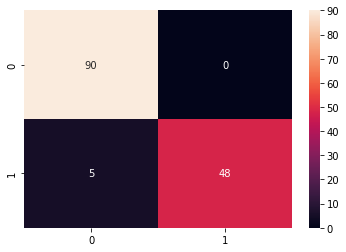

96.5034965034965


In [20]:
y_pred = voting_clf.predict(X_test)
confusion_matrix(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True)
plt.show()
print(accuracy_score(y_test,y_pred)*100)

96/5% Accuracy,could have been better but since we performed cross validation to prevent overfitting and data leakage this results are very good!
<br>We are confident that deploying this model will result in similar accuracy.